HEART LOCATION VISUALIZATION
Analyzing: outputs/frames

Loading frames...
✓ Loaded 130 frames
Calculating difference maps...

✅ Saved: outputs/heart_location_visualization.png
✅ Saved: outputs/heart_location_simple.png

HEART LOCATION ANALYSIS
Heart center location: X=138, Y=221
Heart region size: 20679 pixels (9.5% of image)
Average change score: 29.28
Max change score: 255

DONE!

The bright regions in the heatmap show where the heart is located.
Red areas in the overlay mark the heart region.


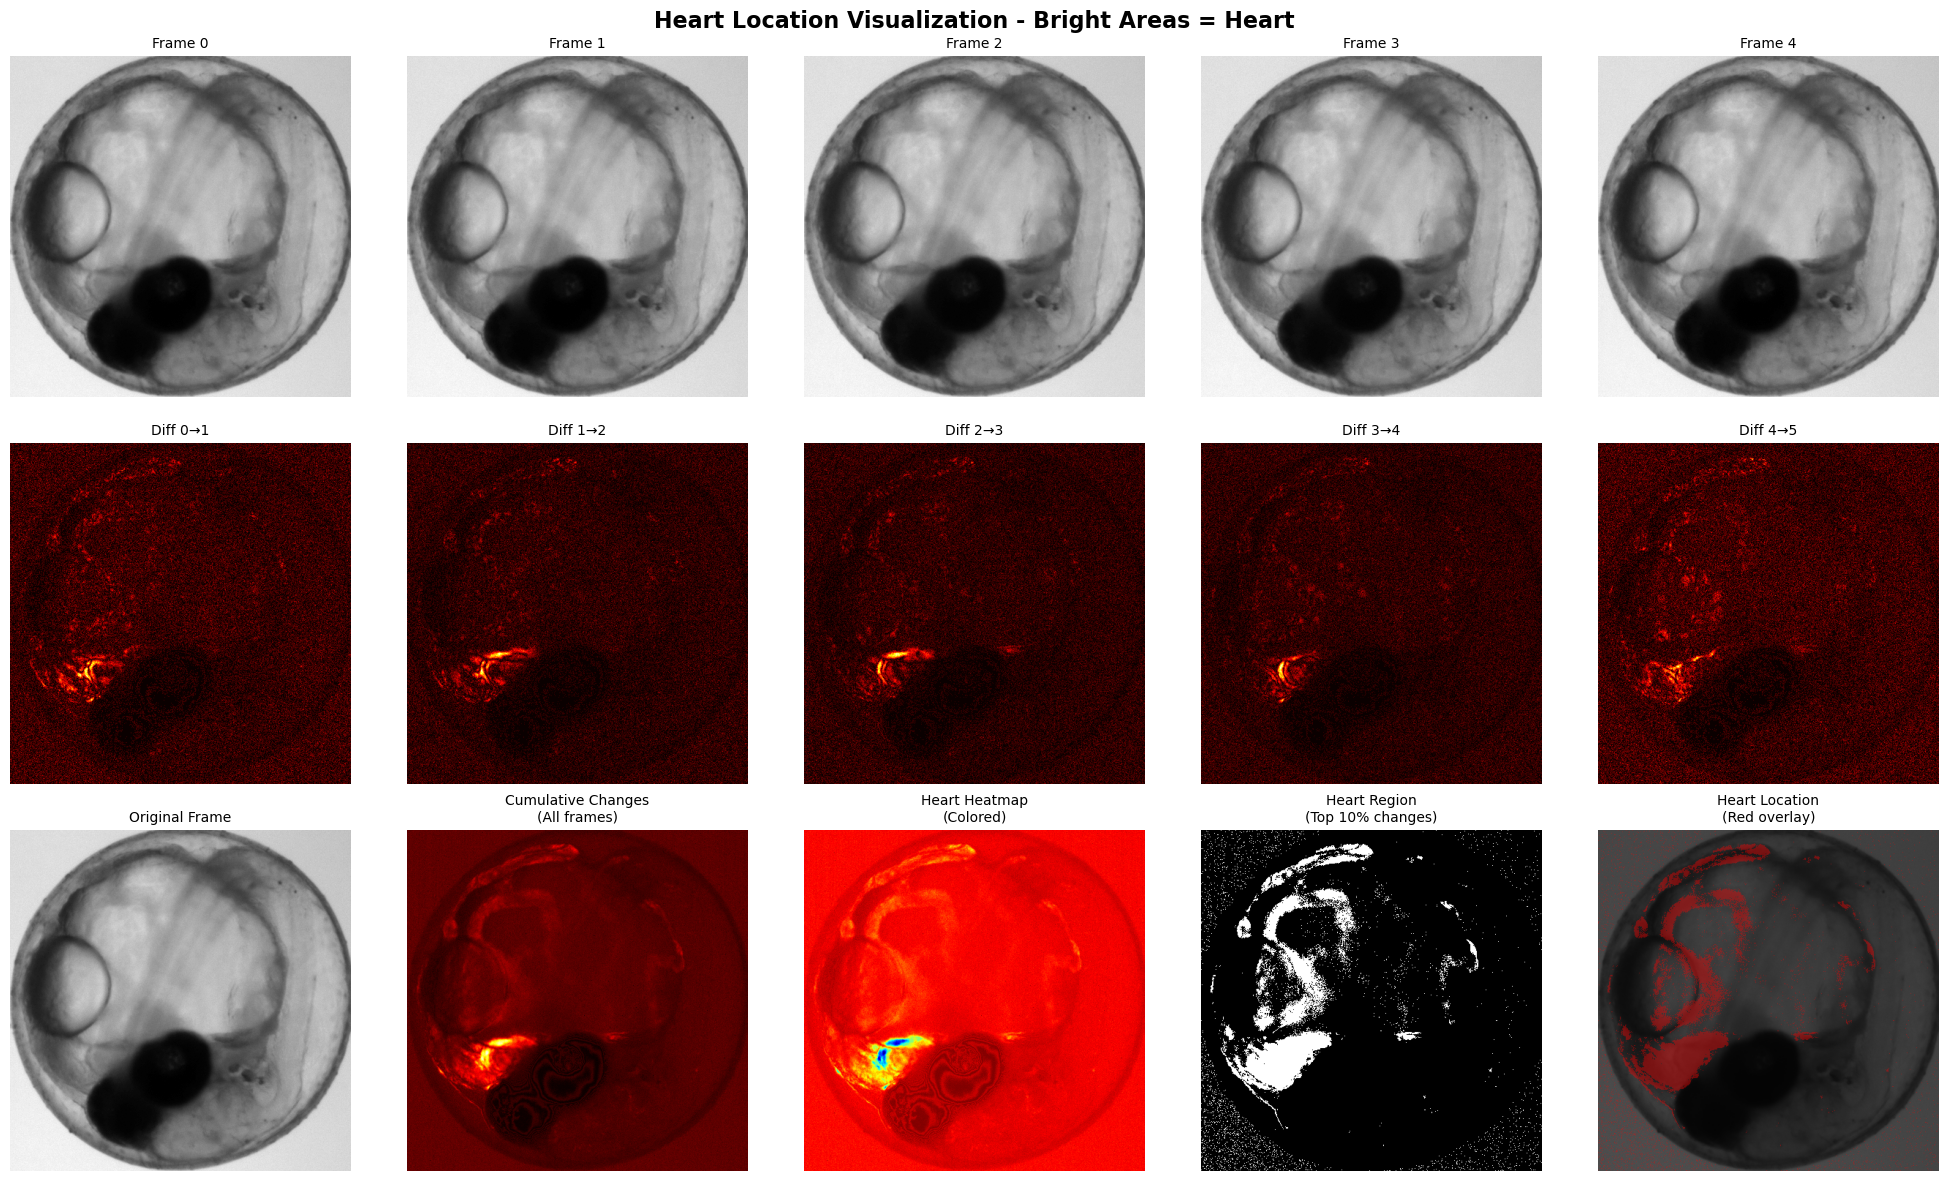

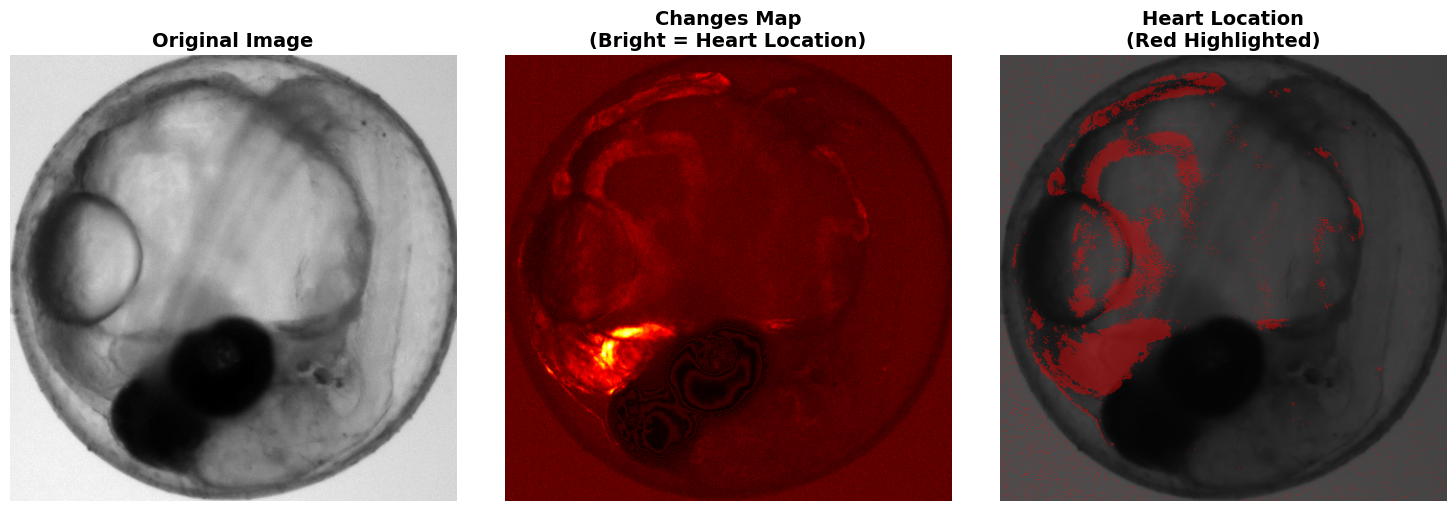

In [1]:
"""
HEART LOCATION VISUALIZATION
=============================
This script shows WHERE the heart is located by visualizing
the overlap differences (regions with most changes).
"""

import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

def load_crop_frames(crop_folder, num_frames=130):
    """
    Load all frames from the crop folder.
    """
    frames = []
    
    for frame_num in range(num_frames):
        img_path = Path(crop_folder) / f"sample_crop_{frame_num:03d}.png"
        
        if img_path.exists():
            img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
            if img is not None:
                frames.append(img)
    
    return frames


def calculate_cumulative_difference_map(frames):
    """
    Calculate cumulative difference map showing where changes occur.
    Bright areas = lots of change = heart location
    """
    if len(frames) < 2:
        return None
    
    # Initialize cumulative difference map
    cumulative_diff = np.zeros_like(frames[0], dtype=np.float32)
    
    # Add up all frame-to-frame differences
    for i in range(len(frames) - 1):
        diff = cv2.absdiff(frames[i], frames[i+1]).astype(np.float32)
        cumulative_diff += diff
    
    # Normalize to 0-255 range
    cumulative_diff = (cumulative_diff / cumulative_diff.max() * 255).astype(np.uint8)
    
    return cumulative_diff


def create_heart_heatmap(frames, threshold_percentile=90):
    """
    Create a heatmap showing heart location.
    Only shows pixels that change more than the threshold.
    """
    cumulative_diff = calculate_cumulative_difference_map(frames)
    
    if cumulative_diff is None:
        return None
    
    # Apply threshold to highlight only high-change areas
    threshold = np.percentile(cumulative_diff, threshold_percentile)
    heart_mask = cumulative_diff > threshold
    
    # Create colored heatmap
    heatmap = cv2.applyColorMap(cumulative_diff, cv2.COLORMAP_JET)
    
    return cumulative_diff, heart_mask, heatmap


def visualize_heart_location(crop_folder, output_folder, num_frames=130):
    """
    Visualize where the heart is located.
    """
    print("Loading frames...")
    frames = load_crop_frames(crop_folder, num_frames)
    
    if len(frames) < 2:
        print(f"❌ Only {len(frames)} frames loaded!")
        return
    
    print(f"✓ Loaded {len(frames)} frames")
    print("Calculating difference maps...")
    
    # Calculate cumulative differences
    cumulative_diff, heart_mask, heatmap = create_heart_heatmap(frames, threshold_percentile=90)
    
    # Calculate average frame
    avg_frame = np.mean([f.astype(np.float32) for f in frames], axis=0).astype(np.uint8)
    
    # Create overlay - show original image with heart region highlighted
    overlay = cv2.cvtColor(frames[0], cv2.COLOR_GRAY2BGR)
    overlay[heart_mask] = [0, 0, 255]  # Red highlight on heart region
    
    # Blend original with overlay
    blended = cv2.addWeighted(
        cv2.cvtColor(frames[0], cv2.COLOR_GRAY2BGR), 
        0.6, 
        overlay, 
        0.4, 
        0
    )
    
    # Create comprehensive visualization
    fig = plt.figure(figsize=(20, 12))
    
    # Row 1: Original frames
    for i in range(5):
        ax = plt.subplot(3, 5, i+1)
        ax.imshow(frames[i], cmap='gray')
        ax.set_title(f'Frame {i}', fontsize=10)
        ax.axis('off')
    
    # Row 2: Difference maps for each transition
    for i in range(5):
        ax = plt.subplot(3, 5, 6+i)
        diff = cv2.absdiff(frames[i], frames[i+1])
        ax.imshow(diff, cmap='hot')
        ax.set_title(f'Diff {i}→{i+1}', fontsize=10)
        ax.axis('off')
    
    # Row 3: Heart location visualizations
    ax = plt.subplot(3, 5, 11)
    ax.imshow(frames[0], cmap='gray')
    ax.set_title('Original Frame', fontsize=10)
    ax.axis('off')
    
    ax = plt.subplot(3, 5, 12)
    ax.imshow(cumulative_diff, cmap='hot')
    ax.set_title('Cumulative Changes\n(All frames)', fontsize=10)
    ax.axis('off')
    
    ax = plt.subplot(3, 5, 13)
    ax.imshow(heatmap)
    ax.set_title('Heart Heatmap\n(Colored)', fontsize=10)
    ax.axis('off')
    
    ax = plt.subplot(3, 5, 14)
    ax.imshow(heart_mask, cmap='gray')
    ax.set_title('Heart Region\n(Top 10% changes)', fontsize=10)
    ax.axis('off')
    
    ax = plt.subplot(3, 5, 15)
    ax.imshow(cv2.cvtColor(blended, cv2.COLOR_BGR2RGB))
    ax.set_title('Heart Location\n(Red overlay)', fontsize=10)
    ax.axis('off')
    
    plt.suptitle('Heart Location Visualization - Bright Areas = Heart', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    output_path = Path(output_folder) / 'heart_location_visualization.png'
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    print(f"\n✅ Saved: {output_path}")
    
    # Create a focused view showing just the heart location
    fig2, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(frames[0], cmap='gray')
    axes[0].set_title('Original Image', fontsize=14, fontweight='bold')
    axes[0].axis('off')
    
    axes[1].imshow(cumulative_diff, cmap='hot')
    axes[1].set_title('Changes Map\n(Bright = Heart Location)', fontsize=14, fontweight='bold')
    axes[1].axis('off')
    
    axes[2].imshow(cv2.cvtColor(blended, cv2.COLOR_BGR2RGB))
    axes[2].set_title('Heart Location\n(Red Highlighted)', fontsize=14, fontweight='bold')
    axes[2].axis('off')
    
    plt.tight_layout()
    
    output_path2 = Path(output_folder) / 'heart_location_simple.png'
    plt.savefig(output_path2, dpi=150, bbox_inches='tight')
    print(f"✅ Saved: {output_path2}")
    
    # Calculate and print statistics
    print("\n" + "="*70)
    print("HEART LOCATION ANALYSIS")
    print("="*70)
    
    # Find center of mass of high-change region
    moments = cv2.moments(heart_mask.astype(np.uint8))
    if moments['m00'] != 0:
        cx = int(moments['m10'] / moments['m00'])
        cy = int(moments['m01'] / moments['m00'])
        print(f"Heart center location: X={cx}, Y={cy}")
    
    total_pixels = heart_mask.size
    heart_pixels = np.sum(heart_mask)
    print(f"Heart region size: {heart_pixels} pixels ({heart_pixels/total_pixels*100:.1f}% of image)")
    print(f"Average change score: {np.mean(cumulative_diff):.2f}")
    print(f"Max change score: {np.max(cumulative_diff)}")
    print("="*70)


def main():
    """
    Main function
    """
    # ========== CONFIGURATION ==========
    crop_folder = "outputs/frames"  # Folder with sample_crop_XXX.png files
    output_folder = "outputs"
    num_frames = 130
    # ===================================
    
    print("="*70)
    print("HEART LOCATION VISUALIZATION")
    print("="*70)
    print(f"Analyzing: {crop_folder}")
    print()
    
    Path(output_folder).mkdir(parents=True, exist_ok=True)
    
    visualize_heart_location(crop_folder, output_folder, num_frames)
    
    print("\n" + "="*70)
    print("DONE!")
    print("="*70)
    print("\nThe bright regions in the heatmap show where the heart is located.")
    print("Red areas in the overlay mark the heart region.")


if __name__ == "__main__":
    main()